In [1]:
from collections import Counter
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")


In [2]:
class Experiment:

  def __init__(self, num_trials, pop_size, p_exposure, infection_period):
    """
    Initialize experiment parameters.

    Params:
      num_trials: Number of trials to conduct.
      pop_size: Size of population as an integer.
      p_exposure: Probability of catching the virus as a float, in range[0,1]; 
        can be a float or a 2-tuple of floats to indicate variation.
      infection_period: Amount of time in days a person is infectious;
        can be an integer or a 2-tuple of integers to indicate variation.
    """
    self._evaluate_inputs(num_trials, pop_size, p_exposure, infection_period)

  def _evaluate_inputs(self, num_trials, pop_size, 
                       p_exposure, infection_period):
    """
    Evaluate inputs into Experiment object instantiation and set them if 
    they meet the requirements.

    Params:
      num_trials: Number of trials to conduct.
      pop_size: Size of population as an integer.
      p_exposure: Probability of catching the virus as a float, in range[0,1].
      infection_period: Amount of time in days a person is infectious.

    Raise ValueError:
      raised when inputs do not meet certain variable types and properties.
    """
    if not isinstance(num_trials, int):
      raise ValueError("num_trials must be an integer!")
    if not isinstance(pop_size, int):
      raise ValueError("pop_size must be an integer!")
    if not isinstance(p_exposure, (float, tuple)):
      raise ValueError("p_exposure must be a float or tuple of two floats!")
    if isinstance(p_exposure, tuple):
      p_arr = np.array(p_exposure)
      p_exposure_truth_cond = (
          False not in set(p_arr >= 0) and 
          False not in set(p_arr <= 1) and 
          isinstance(p_arr[0], float) and 
          isinstance(p_arr[1], float) and
          p_arr[0] < p_arr[1]
      )
      if not p_exposure_truth_cond:
        msg = (
            "p_exposure must be a tuple of two floats (a,b)\n",
            "such that 0 <= a <= 1 and 0 <= b <= 1\n"
            "a < b"
        )
        raise ValueError(msg)
    if not isinstance(infection_period, (int, tuple)):
      raise ValueError("infection_period must be an int or tuple of two ints!")
    if isinstance(infection_period, tuple):
      a,b = infection_period
      infection_period_truth_cond = (
          isinstance(a, int) and
          isinstance(b, int) and 
          a < b
      )
      if not infection_period_truth_cond:
        msg = "infection_period must be a tuple of two ints (a,b) and a < b"
        raise ValueError(msg)
    self._num_trials = num_trials
    self._pop_size = pop_size
    self._p_exposure = p_exposure
    self._infection_period = infection_period

  def run_experiment(self):
    """
    Conduct experiment.

    Returns:
      2-Tuple containing Pandas Dataframes from experiment; trial data, 
        and daily infections raw metadata.
    """
    start = datetime.now()
    daily_infections_counts = Counter([])
    trial_data, epidemic_lengths, max_epidemic_length = \
      self.run_trials()
    for i in range(len(trial_data)):
      daily_infections_counts += Counter(trial_data[i])
      # Make all rows same length based on max_epidemic_length.
      if epidemic_lengths[i] < max_epidemic_length: 
        trial_data[i].extend([0]*(max_epidemic_length - epidemic_lengths[i]))
      trial_data[i].append(epidemic_lengths[i])

    # Build dataframe of all the trial data
    day_columns = [f'D{i}' for i in range(1, 1+max_epidemic_length)]
    columns = day_columns + ['Epidemic_Length (Days)']
    time_elapsed = datetime.now() - start
    print(f"Total time elapsed to gather data for {self._num_trials} trials: "
          f"{time_elapsed}\n\n")
    df = pd.DataFrame(trial_data, columns=columns)
    df['Total_Infections'] = 1 + df[day_columns].sum(axis=1)

    # Build dataframe of all daily infection frequencies
    daily_infection_counts_data = {
        'Number of Daily Infections': [],
        'Frequency': []
    }
    for count in sorted(daily_infections_counts.keys()):
      daily_infection_counts_data['Number of Daily Infections'].append(count)
      daily_infection_counts_data['Frequency'].append(
          daily_infections_counts[count])
    df2 = pd.DataFrame(daily_infection_counts_data)
    df2['Percentage'] = 100*df2['Frequency']/sum(df2['Frequency'])
    return df, df2

  def run_trials(self):
    """
    Conduct all the trials.

    Returns: 3-Tuple consisting of the following
      trial_data: List of trials' metadata.
      epidemic_lengths: List of trials' epidemic lengths.
      max_epidemic_length: The longest epidemic length.
    """
    epidemic_lengths = []
    trial_data = []
    max_epidemic_length = 0
    start = datetime.now()
    # Run all the trials
    for t in range(self._num_trials):
      days, num_recovery, trial_timeseries = self.flu_bern() 
      epidemic_lengths.append(days)
      trial_data.append(trial_timeseries)
      max_epidemic_length = max(max_epidemic_length, days)
    return trial_data, epidemic_lengths, max_epidemic_length

  def _set_values(self):
    """
    Initialize infected person's values for p_exposure and infection_period.

    Returns:
      dictionary: infected person's values for p_exposure and infection_period.
    """
    if isinstance(self._p_exposure, float):
      p = self._p_exposure
    else:
      p = np.random.uniform(*self._p_exposure)
    if isinstance(self._infection_period, int):
      d = self._infection_period
    else:
      d = np.random.randint(*self._infection_period)
    return {'p': p, 'd': d}

  def flu_bern(self, verbose:bool=False):
    """
    Run bernoulli trial simulation for flu spread.

    Params:
      verbose: A boolean flag whether or not to enable debug verbose logs;
                default to False.

    Returns: 3-Tuple consisting of the following
      day: The length of the epidemic as an integer.
      total_infections: The total number of individuals in recovery.
      epidemic_timeseries: The list of daily number of infections.
    """
    # Initialize set of susceptible people.
    susceptible = {i for i in range(1,self._pop_size)}

    # Randomly choose a person who initially is infected.
    first_infected = np.random.randint(1,self._pop_size)

    # Initialize infectious set and recovery set; person infectious for 3 days.

    infectious = {first_infected:self._set_values()} 
    recovery = set([])

    # Remove the first infected person from the susceptible set.
    susceptible.remove(first_infected)

    # Print this if verbose set to True
    if verbose:
      print(f"#######################Initialization#########################")
      print(f"Pr(flu exposure) = {self._p_exposure}")
      print(f"first infected person: {first_infected}")
      print(f"infectious: {infectious}")
      print(f"susceptible: {susceptible}")
      print(f"recovery: {recovery}")
      print("############################################################\n\n")

    # Initialize start of epidemic
    day = 0
    epidemic_timeseries = []

    #HL Note: we may want to add logic here to capture cases when there are 
    #multiple people infected at the beginnning of each day
    #In this case, the remaining susceptible people technically will be exposed 
    #to more interactions
    #Example: if 1 & 2 are already infected
    #3 is exposed after interacting with 1, 4 is NOT exposed after interacting 
    #with 1 but exposed after interacting with 2, etc.

    while 0 < len(infectious) <= self._pop_size:
      day += 1
      # Select the number of daily samples from Unif(0,1) 
      # equal to current number of susceptible people
      # HL note: updated logic here; each person in the susceptible set should 
      # have their own probability of getting infected each day
      sample = np.random.uniform(size=len(susceptible))

      # Each day is a series of iid Bernoulli trials
      # Each Bernoulli trial = one interaction between one infected person and 
      # one susceptible person  
      # If the sample value < p_exposure, the susceptible person becomes 
      # infected; else they remain susceptible
      
      # HL Note: update the logic here so we capture exactly who got exposed 
      # However this is slower than the original code:
      # daily_exposed = [susceptible[i] for i in range(len(susceptible)) if 
      # sample[i] < p_exposure]

      # Set daily exposed to number of remaining susceptible people if number of 
      # susceptible people is less than the daily number of infections to 
      # signify that the virus has been contracted by all members of the 
      # population.

      # Find which of the infected has the highest p_exposure
      max_p_exposure = np.max(np.array([val['p'] 
                                        for val in infectious.values()]))
      num_daily_exposed = np.sum(sample < max_p_exposure)
      
      # Add to epidemic_timeseries to track daily exposures
      epidemic_timeseries.append(num_daily_exposed)

      # Update infectious set: 
      # move people from infectious set to recovery set if they are considered 
      # no longer infectious after 3 days
      for k in infectious.keys():
        infectious[k]['d'] -= 1
        if infectious[k]['d'] == 0:
          recovery.add(k)
      infectious = {k:v for k,v in infectious.items() if v['d'] > 0}

      # Remove num_daily_exposed people from susceptible set
      # Add num_daily_exposed people to infectious sets
      for i in range(num_daily_exposed):
        k = np.random.randint(1,self._pop_size)
        while k not in susceptible: # Must select from susceptible set
          k = np.random.randint(1,self._pop_size)
        # HL Note: updated logic here so we add / remove specific people that 
        # got exposed (not here, in my own copy)
        infectious[k] = self._set_values()
        susceptible.remove(k)
      # Print this if verbose set to True
      if verbose:
        print(f"#################By end of day {day}#####################")
        print(f"sample: {sample}")
        print(f"susceptible: {susceptible}")
        print(f"Number of new exposures: {num_daily_exposed}")
        print(f"infectious: {infectious}")
        print(f"recovery: {recovery}")
        print(f"max_p_exposure: {max_p_exposure}")
        print("###########################################################\n\n")
    # Print this if verbose set to True
    if verbose:
      print(f"Epidemic length in days: {day}\n"
            f"Total infections: {len(recovery)}")
    return day, len(recovery), epidemic_timeseries


def basic_stats(df: pd.DataFrame, cols: list):
  """
  Get statistics, general and grouped.

  Params:
    df: Pandas dataframe

  Return:
    n-tuple of dataframes
  """
  output = [df.describe().T]
  for col in cols:
    output.append(df.groupby(col)[col].count())
  return tuple(output)

In [3]:
experiment = Experiment(10,21,0.02,3)
experiment.flu_bern(verbose=True)

#flu_bern(21, 0.02, 3, verbose=True)

#######################Initialization#########################
Pr(flu exposure) = 0.02
first infected person: 1
infectious: {1: {'p': 0.02, 'd': 3}}
susceptible: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
recovery: set()
############################################################


#################By end of day 1#####################
sample: [0.46284304 0.66480221 0.62417073 0.42249096 0.53078883 0.44526231
 0.79373082 0.37638893 0.28067348 0.86410654 0.35124317 0.91441881
 0.6722946  0.13043345 0.65579053 0.52693435 0.41447583 0.16386045
 0.15490878]
susceptible: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Number of new exposures: 0
infectious: {1: {'p': 0.02, 'd': 2}}
recovery: set()
max_p_exposure: 0.02
###########################################################


#################By end of day 2#####################
sample: [0.92318409 0.97416213 0.57904749 0.74787103 0.96936948 0.11652578
 0.94999111 0.82795064 0.69206576 0.0923

(3, 1, [0, 0, 0])

In [4]:
experiment.run_trials()

([[0, 0, 1, 2, 0, 1, 2, 1, 0, 0, 0],
  [2, 0, 0, 1, 0, 1, 1, 0, 0, 0],
  [0, 0, 1, 2, 0, 0, 0],
  [0, 1, 0, 0, 0],
  [0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
  [0, 1, 0, 0, 1, 0, 0, 0],
  [0, 0, 0],
  [1, 1, 1, 0, 0, 2, 0, 0, 0],
  [0, 0, 0],
  [0, 0, 0]],
 [11, 10, 7, 5, 12, 8, 3, 9, 3, 3],
 12)

In [5]:
test_trial_df, test_dailyinfection_df = experiment.run_experiment()
test_trial_df

Total time elapsed to gather data for 10 trials: 0:00:00.001836




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,Epidemic_Length (Days),Total_Infections
0,1,0,1,0,0,0,0,0,0,0,0,6,3
1,0,1,0,0,0,0,0,0,0,0,0,5,2
2,0,1,1,0,0,0,0,0,0,0,0,6,3
3,0,1,0,0,1,0,1,0,0,0,0,10,4
4,0,0,0,0,0,0,0,0,0,0,0,3,1
5,0,0,1,1,0,0,0,0,0,0,0,7,3
6,0,1,1,1,0,0,0,0,0,0,0,7,4
7,0,1,1,0,1,0,0,0,0,0,0,8,4
8,0,1,0,1,0,1,0,1,0,0,0,11,5
9,1,0,0,0,0,0,0,0,0,0,0,4,2


In [6]:
test_dailyinfection_df

,Number of Daily Infections,Frequency,Percentage
0,0,46,68.656716
1,1,21,31.343284


In [7]:
experiment2 = Experiment(10,21,(0.01,0.1),(3,7))
experiment2.flu_bern(verbose=True)

#######################Initialization#########################
Pr(flu exposure) = (0.01, 0.1)
first infected person: 11
infectious: {11: {'p': 0.01848910419496006, 'd': 6}}
susceptible: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20}
recovery: set()
############################################################


#################By end of day 1#####################
sample: [0.88090639 0.67013434 0.54256911 0.09450791 0.98742699 0.93025647
 0.56417304 0.23733036 0.86772901 0.94307938 0.85750311 0.797464
 0.41009638 0.8996197  0.04320518 0.03265463 0.55962152 0.3896981
 0.57088175]
susceptible: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Number of new exposures: 0
infectious: {11: {'p': 0.01848910419496006, 'd': 5}}
recovery: set()
max_p_exposure: 0.01848910419496006
###########################################################


#################By end of day 2#####################
sample: [0.52137367 0.80991598 0.25288229 0.83899797 0.66598038 0

(26,
 16,
 [0,
  1,
  2,
  2,
  0,
  0,
  1,
  2,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0])

In [8]:
experiment2.run_trials()

([[3, 2, 0, 4, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 1, 4, 0, 4, 2, 0, 1, 1, 0, 0, 0, 0, 0],
  [1, 2, 3, 1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0],
  [2, 2, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 0],
  [2, 0, 1, 1, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
  [0, 1, 2, 2, 1, 1, 0, 0, 1, 2, 1, 1, 0, 0, 0, 0],
  [1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
  [2, 0, 1, 3, 1, 1, 1, 2, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
  [1, 0, 0, 0]],
 [15, 5, 14, 14, 13, 16, 16, 22, 21, 4],
 22)

In [9]:
test_trial_df2, test_dailyinfection_df2 = experiment2.run_experiment()
test_trial_df2

Total time elapsed to gather data for 10 trials: 0:00:00.005147




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D21,D22,D23,D24,D25,D26,D27,D28,Epidemic_Length (Days),Total_Infections
0,1,0,0,1,1,0,0,1,2,0,...,2,0,0,0,1,0,0,0,28,19
1,0,1,1,1,2,3,0,1,1,0,...,0,0,0,0,0,0,0,0,14,11
2,4,3,2,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,26,20
3,1,1,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,20,15
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,1
5,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,5
6,2,2,2,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,22,13
7,1,1,1,2,0,2,4,1,0,0,...,0,0,0,0,0,0,0,0,21,16
8,1,0,1,3,0,1,1,2,1,1,...,0,0,0,0,0,0,0,0,20,15
9,2,1,2,0,0,2,0,0,1,2,...,0,0,0,0,0,0,0,0,18,13


In [10]:
test_dailyinfection_df2

,Number of Daily Infections,Frequency,Percentage
0,0,100,54.945055
1,1,54,29.670330
2,2,22,12.087912
3,3,4,2.197802
4,4,2,1.098901


In [11]:
base_experiment = Experiment(1000000, 21, 0.02, 3)
trial_df, daily_infections_freq_df = base_experiment.run_experiment()
trial_df.head()

Total time elapsed to gather data for 1000000 trials: 0:03:01.559364




,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D28,D29,D30,D31,D32,D33,D34,D35,Epidemic_Length (Days),Total_Infections
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,2
1,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,4
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,2
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,3
4,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,3


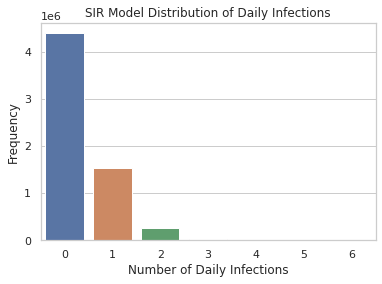

,Number of Daily Infections,Frequency,Percentage
0,0,4391643,70.872617
1,1,1522888,24.576465
2,2,252953,4.082172
3,3,26927,0.434550
4,4,2007,0.032389
5,5,108,0.001743
6,6,4,0.000065


In [12]:
sns.barplot(data = daily_infections_freq_df,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df

In [13]:
# Distribution of epidemic lengths in a trial
stats, groupby_epidemiclength, groupby_totalinfections = \
  basic_stats(trial_df, ['Epidemic_Length (Days)', 'Total_Infections'])

In [14]:
groupby_epidemiclength

Epidemic_Length (Days)
3     316356
4     108317
5     109210
6     109157
7      76229
8      63622
9      52556
10     40039
11     31593
12     24365
13     18714
14     14052
15     10406
16      7532
17      5382
18      3919
19      2826
20      1917
21      1332
22       835
23       627
24       391
25       251
26       154
27        96
28        38
29        28
30        17
31        23
32         6
33         6
34         3
35         1
Name: Epidemic_Length (Days), dtype: int64

In [15]:
# Distribution of total infections in a trial
groupby_totalinfections

Total_Infections
1     316356
2     190481
3     149319
4     112051
5      81031
6      56567
7      38096
8      24051
9      14765
10      8647
11      4673
12      2239
13      1044
14       444
15       157
16        64
17        12
18         3
Name: Total_Infections, dtype: int64

In [16]:
# Statistics per column of all the trial data
stats

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.379631,0.610226,0.0,0.0,0.0,1.0,6.0
D2,1000000.0,0.371987,0.603229,0.0,0.0,0.0,1.0,5.0
D3,1000000.0,0.365611,0.599086,0.0,0.0,0.0,1.0,6.0
D4,1000000.0,0.237428,0.509064,0.0,0.0,0.0,0.0,5.0
D5,1000000.0,0.193491,0.466882,0.0,0.0,0.0,0.0,6.0
D6,1000000.0,0.152764,0.420218,0.0,0.0,0.0,0.0,5.0
D7,1000000.0,0.111606,0.363580,0.0,0.0,0.0,0.0,5.0
D8,1000000.0,0.085121,0.319461,0.0,0.0,0.0,0.0,5.0
D9,1000000.0,0.063207,0.276630,0.0,0.0,0.0,0.0,5.0
D10,1000000.0,0.046188,0.237092,0.0,0.0,0.0,0.0,5.0


In [17]:
base_experiment2 = Experiment(1000000, 21, 0.03, 3)
trial_df2, daily_infections_freq_df2 = base_experiment2.run_experiment()
stats2, groupby_epidemiclength2, groupby_totalinfections2 = \
  basic_stats(trial_df2, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:03:54.833316




In [18]:
trial_df2.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D33,D34,D35,D36,D37,D38,D39,D40,Epidemic_Length (Days),Total_Infections
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,3
1,1,1,2,1,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,10,9
2,0,1,0,0,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,11,6
3,0,0,4,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,9,7
4,2,0,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,6


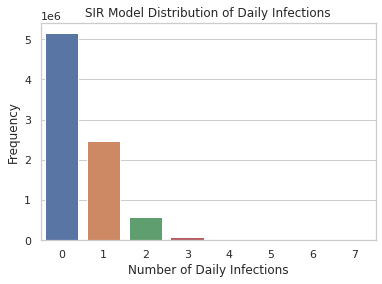

,Number of Daily Infections,Frequency,Percentage
0,0,5148800,62.110835
1,1,2465935,29.746986
2,2,577365,6.964850
3,3,87215,1.052089
4,4,9502,0.114624
5,5,836,0.010085
6,6,42,0.000507
7,7,2,0.000024


In [19]:
sns.barplot(data = daily_infections_freq_df2,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df2

In [20]:
groupby_epidemiclength2

Epidemic_Length (Days)
3     175715
4      87370
5      89915
6      92435
7      79140
8      73035
9      65215
10     57250
11     50625
12     43302
13     37281
14     31389
15     26236
16     20830
17     17037
18     13387
19     10719
20      8142
21      6102
22      4426
23      3266
24      2310
25      1615
26      1152
27       736
28       534
29       320
30       212
31       125
32        73
33        53
34        27
35        10
36        10
37         3
38         2
40         1
Name: Epidemic_Length (Days), dtype: int64

In [21]:
groupby_totalinfections2

Total_Infections
1     175715
2     119755
3     116526
4     108334
5      98141
6      86254
7      74762
8      61887
9      49349
10     37941
11     27571
12     18750
13     11879
14      7029
15      3591
16      1650
17       606
18       211
19        44
20         5
Name: Total_Infections, dtype: int64

In [22]:
stats2

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.571114,0.744979,0.0,0.0,0.0,1.0,6.0
D2,1000000.0,0.552578,0.732669,0.0,0.0,0.0,1.0,7.0
D3,1000000.0,0.536744,0.721812,0.0,0.0,0.0,1.0,6.0
D4,1000000.0,0.419423,0.667224,0.0,0.0,0.0,1.0,6.0
D5,1000000.0,0.361169,0.630990,0.0,0.0,0.0,1.0,6.0
D6,1000000.0,0.304140,0.589357,0.0,0.0,0.0,0.0,6.0
D7,1000000.0,0.248538,0.540101,0.0,0.0,0.0,0.0,6.0
D8,1000000.0,0.205132,0.496354,0.0,0.0,0.0,0.0,6.0
D9,1000000.0,0.165762,0.449695,0.0,0.0,0.0,0.0,5.0
D10,1000000.0,0.132878,0.405233,0.0,0.0,0.0,0.0,5.0


### An Experiment involving Varying Infection Periods

In [23]:
base_experiment3 = Experiment(1000000, 21, 0.02, (3,7))
trial_df3, daily_infections_freq_df3 = base_experiment3.run_experiment()
stats3, groupby_epidemiclength3, groupby_totalinfections3 = \
  basic_stats(trial_df3, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:05:22.912681




In [24]:
trial_df3

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D58,D59,D60,D61,D62,D63,D64,D65,Epidemic_Length (Days),Total_Infections
0,1,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,11,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,34,13
3,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,22,9
4,0,0,1,0,0,1,0,1,0,2,...,0,0,0,0,0,0,0,0,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,1,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,14,6
999996,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,24,8
999997,1,1,0,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,10,6
999998,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,23,8


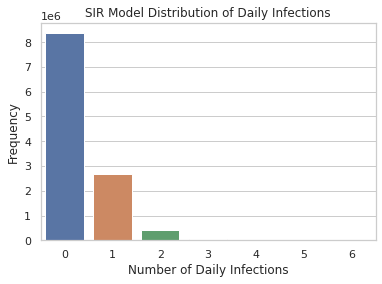

,Number of Daily Infections,Frequency,Percentage
0,0,8361888,72.730075
1,1,2674353,23.261002
2,2,416122,3.619348
3,3,41693,0.362638
4,4,2888,0.025119
5,5,200,0.001740
6,6,9,0.000078


In [25]:
sns.barplot(data = daily_infections_freq_df3,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df3

In [26]:
groupby_epidemiclength3

Epidemic_Length (Days)
3     79526
4     65138
5     68872
6     83989
7     62627
8     60899
9     58681
10    54606
11    50692
12    46859
13    42871
14    39306
15    35720
16    32316
17    29295
18    26182
19    23562
20    20757
21    18065
22    16024
23    13558
24    11735
25    10212
26     8669
27     7419
28     6198
29     4991
30     4204
31     3632
32     2808
33     2280
34     1831
35     1481
36     1183
37      871
38      695
39      573
40      408
41      345
42      266
43      185
44      135
45      104
46       68
47       50
48       31
49       26
50       15
51       12
52       10
53        4
54        2
55        5
57        3
58        2
60        1
65        1
Name: Epidemic_Length (Days), dtype: int64

In [27]:
groupby_totalinfections3

Total_Infections
1     195007
2     133828
3     119548
4     108025
5      95847
6      83233
7      69832
8      56862
9      44423
10     33384
11     23778
12     15893
13      9858
14      5632
15      2921
16      1243
17       494
18       156
19        30
20         6
Name: Total_Infections, dtype: int64

In [28]:
stats3

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.379907,0.609948,0.0,0.0,0.0,1.0,6.0
D2,1000000.0,0.372021,0.604356,0.0,0.0,0.0,1.0,6.0
D3,1000000.0,0.365150,0.598734,0.0,0.0,0.0,1.0,6.0
D4,1000000.0,0.327293,0.575024,0.0,0.0,0.0,1.0,6.0
D5,1000000.0,0.295001,0.551364,0.0,0.0,0.0,1.0,5.0
...,...,...,...,...,...,...,...,...
D63,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
D64,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
D65,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Epidemic_Length (Days),1000000.0,11.497153,7.069597,3.0,6.0,10.0,16.0,65.0


### An Experiment involving Varying Infection Probabilities

In [29]:
base_experiment4 = Experiment(1000000, 21, (0.01,0.05), 3)
trial_df4, daily_infections_freq_df4 = base_experiment4.run_experiment()
stats4, groupby_epidemiclength4, groupby_totalinfections4 = \
  basic_stats(trial_df4, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:04:35.053965




In [30]:
trial_df4

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D31,D32,D33,D34,D35,D36,D37,D38,Epidemic_Length (Days),Total_Infections
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
2,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,5
3,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,5
4,1,1,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,11,5
999996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
999997,0,2,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,25,14
999998,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,5


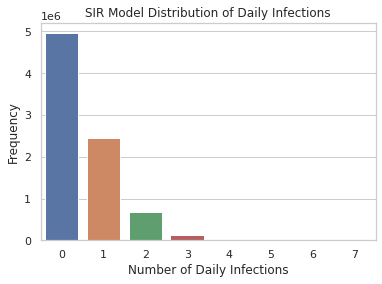

,Number of Daily Infections,Frequency,Percentage
0,0,4956223,60.312770
1,1,2448736,29.798912
2,2,666073,8.105509
3,3,126241,1.536239
4,4,18003,0.219080
5,5,2055,0.025007
6,6,192,0.002336
7,7,12,0.000146


In [31]:
sns.barplot(data = daily_infections_freq_df4,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df4

In [32]:
groupby_epidemiclength4

Epidemic_Length (Days)
3     218543
4      65546
5      76468
6      89318
7      71933
8      69708
9      65354
10     57297
11     52313
12     45201
13     38747
14     32645
15     27081
16     21948
17     17458
18     13520
19     10490
20      8019
21      5666
22      4128
23      2875
24      1987
25      1386
26       914
27       591
28       367
29       208
30       132
31        71
32        33
33        29
34        13
35         5
36         2
37         1
38         3
Name: Epidemic_Length (Days), dtype: int64

In [33]:
groupby_totalinfections4

Total_Infections
1     218543
2     106723
3      90260
4      83613
5      79626
6      74965
7      69599
8      63242
9      55132
10     46252
11     36802
12     28059
13     20041
14     12989
15      7645
16      4045
17      1705
18       578
19       163
20        18
Name: Total_Infections, dtype: int64

In [34]:
stats4

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.569521,0.773752,0.0,0.0,0.0,1.0,7.0
D2,1000000.0,0.591543,0.782450,0.0,0.0,0.0,1.0,7.0
D3,1000000.0,0.605934,0.787032,0.0,0.0,0.0,1.0,7.0
D4,1000000.0,0.460813,0.724429,0.0,0.0,0.0,1.0,7.0
D5,1000000.0,0.404884,0.688297,0.0,0.0,0.0,1.0,6.0
D6,1000000.0,0.343738,0.643067,0.0,0.0,0.0,1.0,6.0
D7,1000000.0,0.276232,0.584664,0.0,0.0,0.0,0.0,6.0
D8,1000000.0,0.227821,0.534467,0.0,0.0,0.0,0.0,6.0
D9,1000000.0,0.182670,0.482249,0.0,0.0,0.0,0.0,6.0
D10,1000000.0,0.144941,0.432018,0.0,0.0,0.0,0.0,6.0


### An Experiment invovling both Varying Infection Probabilities and Periods

In [35]:
base_experiment5 = Experiment(1000000, 21, (0.01,0.05), (3,7))
trial_df5, daily_infections_freq_df5 = base_experiment5.run_experiment()
stats5, groupby_epidemiclength5, groupby_totalinfections5 = \
  basic_stats(trial_df5, ['Epidemic_Length (Days)', 'Total_Infections'])

Total time elapsed to gather data for 1000000 trials: 0:08:40.371177




In [36]:
trial_df5

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D52,D53,D54,D55,D56,D57,D58,D59,Epidemic_Length (Days),Total_Infections
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,4
1,1,3,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,15,8
2,0,1,0,2,1,2,1,2,0,1,...,0,0,0,0,0,0,0,0,24,16
3,2,0,0,1,1,1,1,1,2,1,...,0,0,0,0,0,0,0,0,19,13
4,1,1,0,1,0,2,1,3,1,0,...,0,0,0,0,0,0,0,0,13,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,4
999996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,2
999997,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,2
999998,0,0,3,1,0,1,1,1,3,0,...,0,0,0,0,0,0,0,0,16,12


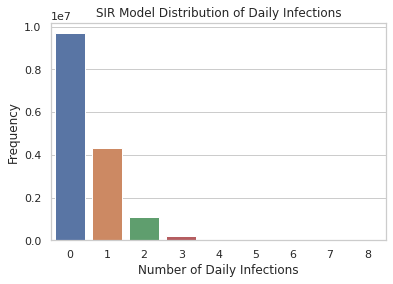

,Number of Daily Infections,Frequency,Percentage
0,0,9694637,63.384839
1,1,4298971,28.107250
2,2,1079959,7.060917
3,3,192237,1.256871
4,4,25994,0.169952
5,5,2820,0.018438
6,6,247,0.001615
7,7,17,0.000111
8,8,1,0.000007


In [37]:
sns.barplot(data = daily_infections_freq_df5,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df5

In [38]:
groupby_epidemiclength5

Epidemic_Length (Days)
3     54437
4     42342
5     40254
6     44841
7     32509
8     34686
9     37331
10    38667
11    40279
12    41526
13    42415
14    43105
15    42325
16    42344
17    41822
18    40302
19    38615
20    36307
21    33831
22    31452
23    28851
24    26021
25    23181
26    20520
27    17721
28    15505
29    13240
30    11094
31     9302
32     7616
33     6094
34     4988
35     3965
36     3080
37     2450
38     1828
39     1407
40     1015
41      769
42      584
43      391
44      307
45      239
46      129
47       93
48       78
49       41
50       35
51       22
52       15
53       13
54       10
55        1
56        2
57        1
59        2
Name: Epidemic_Length (Days), dtype: int64

In [39]:
groupby_totalinfections5

Total_Infections
1     131716
2      58662
3      47408
4      46343
5      48850
6      53192
7      57784
8      62740
9      66843
10     69263
11     69701
12     67402
13     61599
14     53326
15     42354
16     30273
17     18714
18      9576
19      3528
20       726
Name: Total_Infections, dtype: int64

In [40]:
stats5

,count,mean,std,min,25%,50%,75%,max
D1,1000000.0,0.570319,0.773832,0.0,0.0,0.0,1.0,8.0
D2,1000000.0,0.590959,0.782131,0.0,0.0,0.0,1.0,7.0
D3,1000000.0,0.605852,0.786605,0.0,0.0,0.0,1.0,7.0
D4,1000000.0,0.573043,0.773177,0.0,0.0,0.0,1.0,7.0
D5,1000000.0,0.541252,0.758237,0.0,0.0,0.0,1.0,7.0
...,...,...,...,...,...,...,...,...
D57,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
D58,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
D59,1000000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Epidemic_Length (Days),1000000.0,15.294883,8.297166,3.0,9.0,15.0,21.0,59.0


## Data Viz

In [41]:
#!pip install -U matplotlib

In [42]:
def long(df, pop_size):
  """
  This function takes the output df from run_experiment()
  and cleans and transforms data for epidimiological graphing.
  The df is melted to a long form on the variables, simulation and day.
  Additional variable created include cummulative totals for infections, 
  recovered agents, and susceptible agents.

  Params:
    df: Pandas dataframe,
    pop_size: Size of population as an integer.

  Returns: 
    Pandas dataframe melted and transformed.
  """
  #cleaning orginal df
  long_df = df.copy()
  long_df.drop(columns=long_df.columns[-2:], axis=1,  inplace=True)
  long_df.reset_index(inplace=True)

  #creating simulation column
  long_df = long_df.rename(columns = {'index':'simulation'}) 

  #melting on simulation and day
  long_df = long_df.melt(id_vars=['simulation'], 
                         var_name = "day", 
                         value_name = "infections")
  #removing "D" from day values
  long_df['day'] = long_df["day"].map(lambda x: x.lstrip('D')).astype(int)

  #creating cumulative sum of infections for each day
  long_df['infections'] = long_df['infections'].astype(int)
  long_df = long_df.sort_values(["simulation", "day"])
  long_df['total infections'] = long_df.groupby(['simulation'])\
    ['infections'].cumsum().astype(int)
   
  #creating cumulative sum of recovered agents for each day
  long_df['recovered'] = long_df['total infections'].shift(
      3, axis = 0, fill_value = 0).astype(int)
  long_df.loc[long_df.day == 1, 'recovered'] = 0
  long_df.loc[long_df.day == 2, 'recovered'] = 0
  long_df.loc[long_df.day == 3, 'recovered'] = 0

  #creating susceptible value for each day
  long_df['susceptible'] = pop_size - long_df['total infections']
  long_df = long_df.sort_values(["simulation", "day"])
  return long_df

In [43]:
base_experiment_10k = Experiment(10000, 21, 0.02, 3)
df_10k, daily_infections_freq_df_10k = base_experiment_10k.run_experiment()
long_df_10k = long(df_10k, 21)
long_df_10k

Total time elapsed to gather data for 10000 trials: 0:00:01.668068




,simulation,day,infections,total infections,recovered,susceptible
0,0,1,0,0,0,21
10000,0,2,0,0,0,21
20000,0,3,0,0,0,21
30000,0,4,0,0,0,21
40000,0,5,0,0,0,21
...,...,...,...,...,...,...
279999,9999,28,0,0,0,21
289999,9999,29,0,0,0,21
299999,9999,30,0,0,0,21
309999,9999,31,0,0,0,21


Text(0.5, 1.0, 'SIR Model Distribution of Epidemic Length')

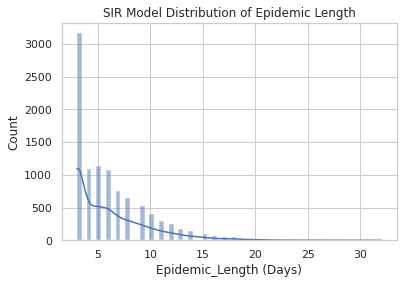

In [44]:
sns.histplot(data = df_10k, x = "Epidemic_Length (Days)", kde = True)
plt.title('SIR Model Distribution of Epidemic Length')

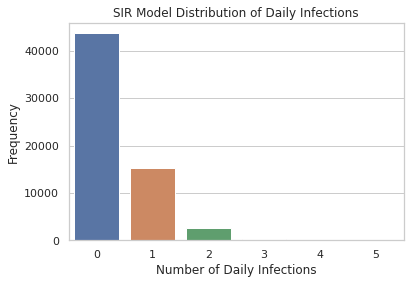

,Number of Daily Infections,Frequency,Percentage
0,0,43700,70.726852
1,1,15248,24.678330
2,2,2549,4.125463
3,3,265,0.428893
4,4,23,0.037225
5,5,2,0.003237


In [45]:
sns.barplot(data = daily_infections_freq_df_10k,
            x = "Number of Daily Infections",
            y = 'Frequency')
plt.title('SIR Model Distribution of Daily Infections')
plt.show()
daily_infections_freq_df_10k

Text(0.5, 1.0, 'SIR Model Distribution of Infection Totals')

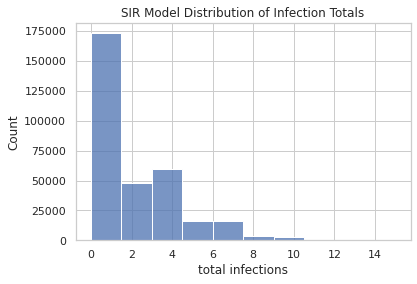

In [46]:
sns.histplot(data = long_df_10k, x = "total infections", bins = 10)
plt.title('SIR Model Distribution of Infection Totals')

Text(0.5, 1.0, 'SIR Model Mean Daily Infections Time Series')

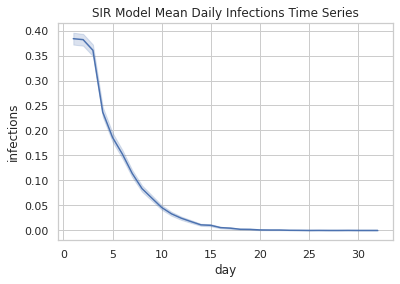

In [47]:
sns.lineplot(x = "day", y = "infections", data = long_df_10k)
plt.title('SIR Model Mean Daily Infections Time Series')

Text(0.5, 1.0, 'SIR Model Mean Total Infections Time Series')

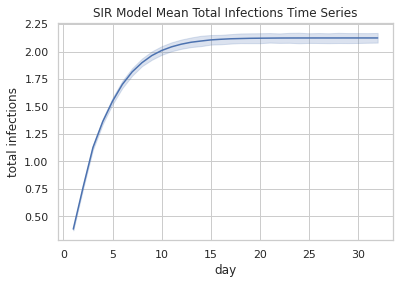

In [48]:
sns.lineplot(x = "day", y = "total infections", data = long_df_10k)
plt.title('SIR Model Mean Total Infections Time Series')

In [49]:
sir_df_10k = long_df_10k.melt(
    id_vars=['simulation', 'day'],
    value_vars = ["total infections", "recovered", "susceptible"]
)
sir_df_10k

,simulation,day,variable,value
0,0,1,total infections,0
1,0,2,total infections,0
2,0,3,total infections,0
3,0,4,total infections,0
4,0,5,total infections,0
...,...,...,...,...
959995,9999,28,susceptible,21
959996,9999,29,susceptible,21
959997,9999,30,susceptible,21
959998,9999,31,susceptible,21


Text(0.5, 1.0, 'SIR Model Infections Time Series')

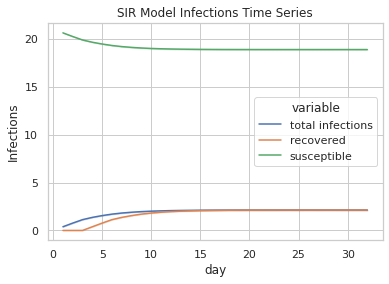

In [50]:
sns.lineplot(x = "day", y = "value", data = sir_df_10k, hue = "variable")
plt.ylabel('Infections')
plt.title('SIR Model Infections Time Series')

### Plotting each simulation

In [51]:
experiment_100 = Experiment(100, 200, 0.02, 3)
df_100, daily_infections_freq_df_100 = experiment_100.run_experiment()
long_df_100 = long(df_100, 200)

Total time elapsed to gather data for 100 trials: 0:00:00.253232




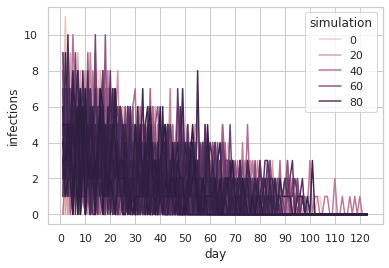

In [52]:
plt = sns.lineplot(data = long_df_100, x = "day", y = "infections", hue = "simulation")
plt.xaxis.set_major_locator(ticker.MultipleLocator(10))

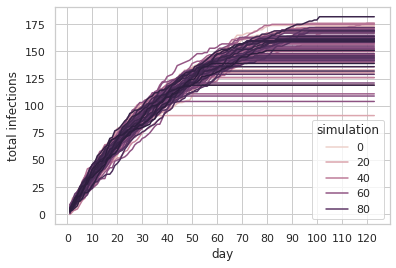

In [53]:
plt = sns.lineplot(data = long_df_100 , x = "day", y = "total infections", hue = "simulation")
plt.xaxis.set_major_locator(ticker.MultipleLocator(10))

## Additional Analysis
This section includes:

* Effect of varied infection probability
* Effect of varied infection length
* Effect of varied class size


In [54]:
import matplotlib.pyplot as plt
def coupled_experiments(params, epi_len, dfs, index, val):
  """
  Run a set of experiments and update epidemic lengths and dfs passed by ref.

  Params:
    params: tuple of parameters for Experiment.
    epi_len: Pandas dataframe of epidemic lengths.
    dfs: Dictionary of Pandas dataframes.
    index: integer index as key for entry into dfs.
    val: value of a variable which to assess its effects on.
  """
  expdf, daily_infection_freq_expdf = Experiment(*params).run_experiment()
  epi_len[str(val)] = expdf[["Epidemic_Length (Days)"]]
  dfs[index] = long(expdf, params[1])


def data_varying_infection_probs(infection_probs, num_trials, 
                                 pop_size, infection_period):
  """
  Visualize the effect of varying infection probabilities in epidemic.

  Params:
    infection_probs: list of infection probabilities.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes.
  """
  prob_dfs = {}
  epi_len = pd.DataFrame()
  for i,p in enumerate(infection_probs):
    coupled_experiments(
        (num_trials, pop_size, p, infection_period),
        epi_len,
        prob_dfs,
        i,
        p
    )
  epi_len.reset_index(inplace=True)
  epi_len = epi_len.rename(columns = {'index':'simulation'})
  epi_len = epi_len.melt(id_vars=['simulation'], 
                         var_name = "infection probability", 
                         value_name = "length of epidemic")
  return epi_len, prob_dfs


def data_varying_effect_infection_lengths(infection_lengths, num_trials, 
                                          pop_size, p_exposure):
  """
  Visualize the effect of varying infection length in epidemic.

  Params:
    infection_lengths: list of infection period lengths.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes.
  """
  #infection_lengths = [1,2,3,4,5]
  l_dfs = {}
  epi_len2 = pd.DataFrame()
  for i,l in enumerate(infection_lengths):
    coupled_experiments(
        (num_trials, pop_size, p_exposure, l),
        epi_len2,
        l_dfs,
        i,
        l
    )
  epi_len2.reset_index(inplace=True)
  epi_len2 = epi_len2.rename(columns = {'index':'simulation'})
  epi_len2 = epi_len2.melt(id_vars=['simulation'], 
                           var_name = "infection length", 
                           value_name = "length of epidemic")
  return epi_len2, l_dfs


def data_varying_effect_class_size(class_size, num_trials, p_exposure, 
                                   infection_period):
  """
  Visualize the effect of varying class size.

  Params:
    class_size: list of class size.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes
  """
  #class_size = [*range(10, 101, 10)]
  c_dfs = {}
  epi_len3 = pd.DataFrame()
  for i,c in enumerate(class_size):
    coupled_experiments(
        (num_trials, c, p_exposure, infection_period),
        epi_len3,
        c_dfs,
        i,
        c
    )
  epi_len3.reset_index(inplace=True)
  epi_len3 = epi_len3.rename(columns = {'index':'simulation'})
  epi_len3 = epi_len3.melt(id_vars=['simulation'], 
                           var_name = "class size", 
                           value_name = "length of epidemic")
  return epi_len3, c_dfs


def run_variation_analysis(num_trials, pop_size, p_exposure, infection_period):
  """
  Run experiments with one of the key parameters as a list.

  Params:
    num_trials: Must be an integer.
    pop_size: Can be either an integer or a list of integers.
    p_exposure: can be either a float or a list of floats.
    infection_period: can be either an integer or a list of integers.

  Returns:
    2-tuple of Epidemic Lengths dataframe and Dictionary of Pandas dataframes
  """
  if not isinstance(num_trials, int):
    raise ValueError("num_trials must be an integer!")
  if (isinstance(pop_size, list), 
      isinstance(p_exposure, float), 
      isinstance(infection_period, int)) == (True, True, True):
      return data_varying_effect_class_size(
          pop_size, 
          num_trials, 
          p_exposure, 
          infection_period
      )
  if (isinstance(pop_size, int), 
      isinstance(p_exposure, list), 
      isinstance(infection_period, int)) == (True, True, True):
      return data_varying_infection_probs(
          p_exposure, 
          num_trials, 
          pop_size,
          infection_period
      )
  if (isinstance(pop_size, int), 
      isinstance(p_exposure, float), 
      isinstance(infection_period, list)) == (True, True, True):
      return data_varying_effect_infection_lengths(
          infection_period, 
          num_trials,
          pop_size, 
          p_exposure
      )
  raise RuntimeError(
      "Check your inputs into this function and try again!"
      "Hint: num_trials must always be a int; as for the rest of the variables,"
      " only one of them can be a list!"
  )


def graph_against_epidemic_lengths(epi_len, x, hue_quantity, bins):
  """
  Graph against epidemic lengths.

  Params:
    epi_len: Pandas dataframe of epidemic lengths.
    x: x-axis label.
    hue_quantity: hue property which is also the quantity of interest.
    bins: Number of bins.
  """
  fig, ax =plt.subplots(1,2)
  sns.histplot(data = epi_len, x = x, hue = hue_quantity, bins = bins, ax=ax[0])
  sns.histplot(data = epi_len, x = x, hue = hue_quantity, 
               bins = bins, element = "poly", ax=ax[1])
  fig.set_size_inches(15, 4)
  fig.suptitle(f'Effect of {hue_quantity} on Epidemic Length')


def graph_against_infection_counts(vals, dfs, x, y1, y2, 
                                   label, quantity, legend=None):
  """
  Graph against infection counts.

  Params:
    vals: list of values.
    dfs: Dictionary of Pandas dataframes.
    x: x-axis label.
    y1: y-axis label for first graph.
    y2: y-axis label for second graph.
    label: legend label.
    quantity: actual variable of interest.
    legend: Legend parameter; default to None as parameter is optional.
  """
  fig, ax = plt.subplots(1,2)
  for i,v in enumerate(vals):
    sns.lineplot(x = x, y = y1, data = dfs[i], 
                 label =f'{label} = {v}', ax=ax[0])
    sns.lineplot(x = x, y = y2, data = dfs[i], 
                 label =f'{label} = {v}', ax=ax[1])
  fig.set_size_inches(15, 4)
  fig.suptitle(f'Effect of {quantity} on Infection Counts')
  if legend:
    fig.legend(title = legend)

### Varied Infection probability
$N = 21$, $\text{infection period (days)} = 3$

In [55]:
p_exposures = [.01, .02, .03, .04, .05]
epi_len1, prob_dfs = run_variation_analysis(10000, 21, p_exposures, 3)

Total time elapsed to gather data for 10000 trials: 0:00:01.410824


Total time elapsed to gather data for 10000 trials: 0:00:01.725047


Total time elapsed to gather data for 10000 trials: 0:00:02.608558


Total time elapsed to gather data for 10000 trials: 0:00:03.156624


Total time elapsed to gather data for 10000 trials: 0:00:03.425335




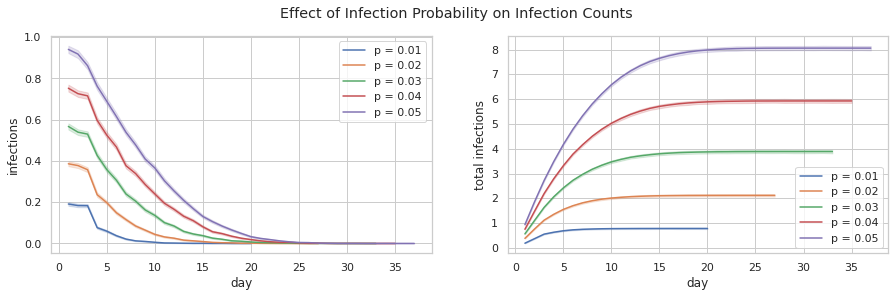

In [56]:
graph_against_infection_counts(p_exposures, 
                               prob_dfs,
                               "day",
                               "infections",
                               "total infections",
                               'p',
                               'Infection Probability')

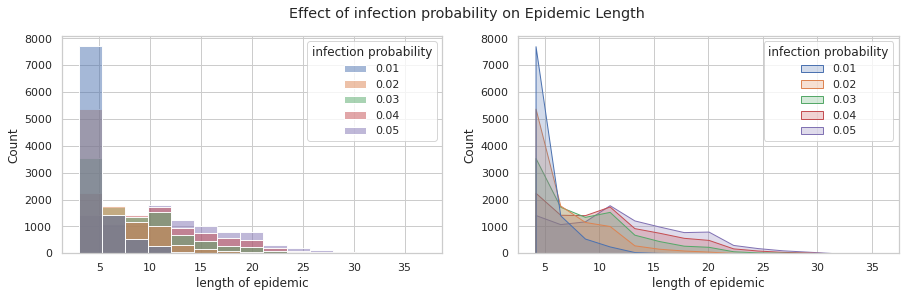

In [57]:
graph_against_epidemic_lengths(epi_len1,
                               "length of epidemic",
                               "infection probability",
                               15)

### Varied Infection Length

$N=21$, $p=0.02$

In [58]:
infection_periods = [1,2,3,4,5]
epi_len2, l_dfs = run_variation_analysis(10000, 21, 0.02, infection_periods)

Total time elapsed to gather data for 10000 trials: 0:00:00.828296


Total time elapsed to gather data for 10000 trials: 0:00:01.102375


Total time elapsed to gather data for 10000 trials: 0:00:01.676171


Total time elapsed to gather data for 10000 trials: 0:00:02.530696


Total time elapsed to gather data for 10000 trials: 0:00:03.895039




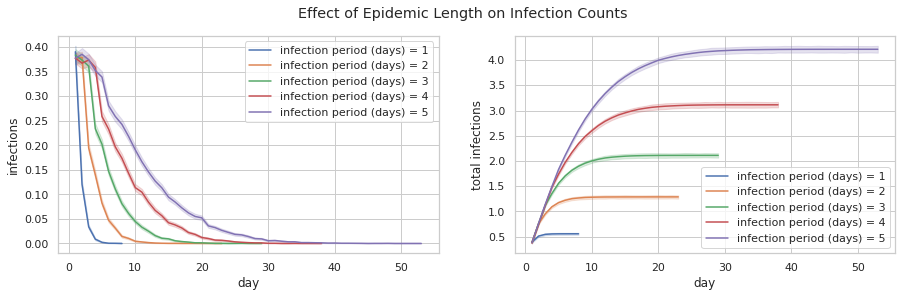

In [59]:
graph_against_infection_counts(infection_periods, 
                               l_dfs,
                               "day",
                               "infections",
                               "total infections",
                               'infection period (days)',
                               'Epidemic Length')

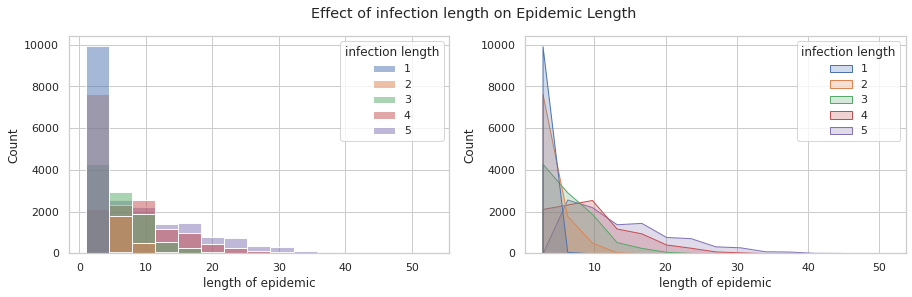

In [60]:
graph_against_epidemic_lengths(epi_len2,
                               "length of epidemic",
                               "infection length",
                               15)

### Varied Class Size

$p=0.02$, $\text{infection period (days)} = 3$

In [61]:
pop_sizes = [*range(10, 101, 10)]
epi_len3, c_dfs = run_variation_analysis(10000, pop_sizes, 0.02, 3)

Total time elapsed to gather data for 10000 trials: 0:00:01.235434


Total time elapsed to gather data for 10000 trials: 0:00:01.667584


Total time elapsed to gather data for 10000 trials: 0:00:02.577974


Total time elapsed to gather data for 10000 trials: 0:00:03.369163


Total time elapsed to gather data for 10000 trials: 0:00:04.703806


Total time elapsed to gather data for 10000 trials: 0:00:06.002576


Total time elapsed to gather data for 10000 trials: 0:00:07.225829


Total time elapsed to gather data for 10000 trials: 0:00:09.478014


Total time elapsed to gather data for 10000 trials: 0:00:10.854508


Total time elapsed to gather data for 10000 trials: 0:00:11.906276




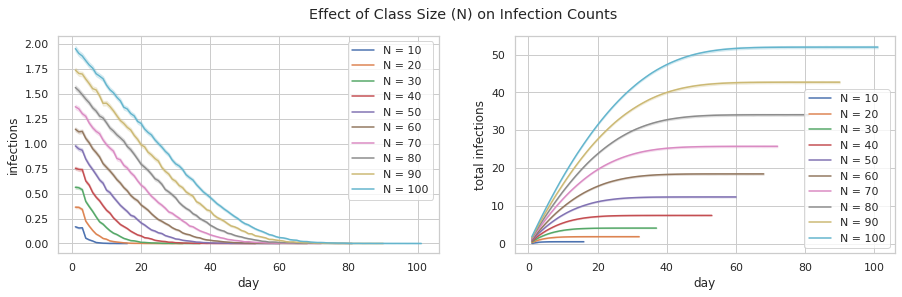

In [62]:
graph_against_infection_counts(pop_sizes, 
                               c_dfs,
                               "day",
                               "infections",
                               "total infections",
                               'N',
                               "Class Size (N)")

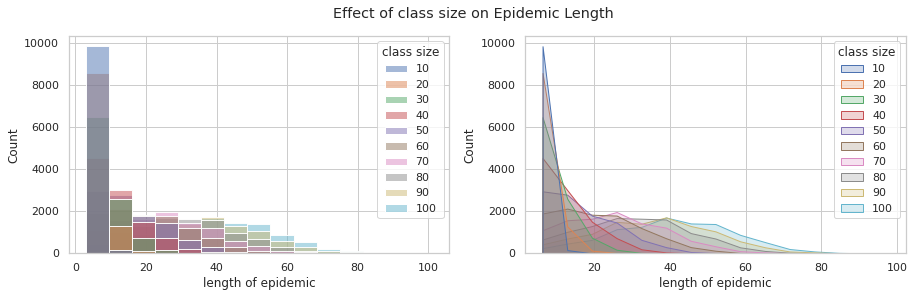

In [63]:
graph_against_epidemic_lengths(epi_len3,
                               "length of epidemic",
                               "class size",
                               15)